# Include functions from function file

In [1]:

cd("C:/Users/mjbarillas/Documents/GitHub/Mimosa/")


In [ ]:
pwd()

## Include

In [2]:
include("C:/Users/mjbarillas/Documents/GitHub/Mimosa/scripts/MB Ex/kPCA/TB/ex2_aa_kPCA_TB_ST4SL4.jl")

Voltage_Optimization2 (generic function with 1 method)

## Plots Backends

In [3]:
plotlyjs(size=(800,800))


Plots.PlotlyJSBackend()

In [ ]:
gr(size=(800,800))

# ROM offline

## Data collection

In [4]:
St, Sl, pot_list, N_rand = 4, 4, [2000,3000,4000,5000], 200
conf_list, X = ReadData(St,Sl,pot_list,N_rand)

([0 1 … 0 1; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 1 0], [0.0 0.0 … 0.0 0.0; 0.003571428571430387 0.0035760141855762546 … 0.0035995839865282614 0.003631334138149885; … ; -3.049318610115481e-20 -0.0039130996209062715 … 0.03137838629882813 0.013757098424891907; -3.105787473265768e-20 -0.004079949356178715 … 0.03355656085819472 0.013758706435503686])

In [5]:
_,N = size(X)

(87, 1056)

## Plot test

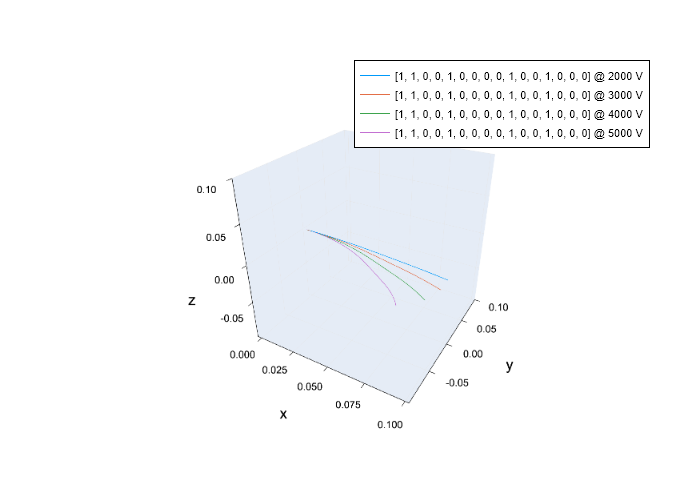

In [6]:
conf_i = 970-264*3
p = plot_x(X[:,conf_i],"$(conf_list[:,conf_i]) @ 2000 V")
for i in 1:3
    p = plot_x!(X[:,conf_i+264*i],"$(conf_list[:,conf_i]) @ $((i+2)*1000) V")
end
zlims!(-0.1,0.1); ylims!(-0.1,0.1)

## kPCA

Previously optimized values of $\beta$ for each of the potentials computed (i.e. 1000, 2000, 3000, 4000, 5000) 

In [ ]:
β_list = [816.077739050131, 46.97993387012737, 5.5027923359124, 9.563901355786785e-7, 4.515461700136166e-7]


In [ ]:
β = sum([β_list[1],β_list[3],β_list[5]])/3
β = 100 # 5.5027923359124


In [ ]:
β = β_list[4]


Optimized $\beta$ for TS with voltages 2000:1000:5000

In [7]:
β = 2.5917492241092597

2.5917492241092597

In [8]:
k=3
Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
Λ, U, U_, Ḡ, G = kPOD(Κ, X, k)
Z_ = real.(U_'*Ḡ)

3×1056 Matrix{Float64}:
 0.00712608  0.0174332   0.0441908   0.0412031  …  -0.255478   -0.101587
 0.00034768  0.0373126  -0.00997746  0.0195159      0.0722624  -0.0117681
 0.0163449   0.0141049   0.015296    0.014669      -0.0686469   0.00363381

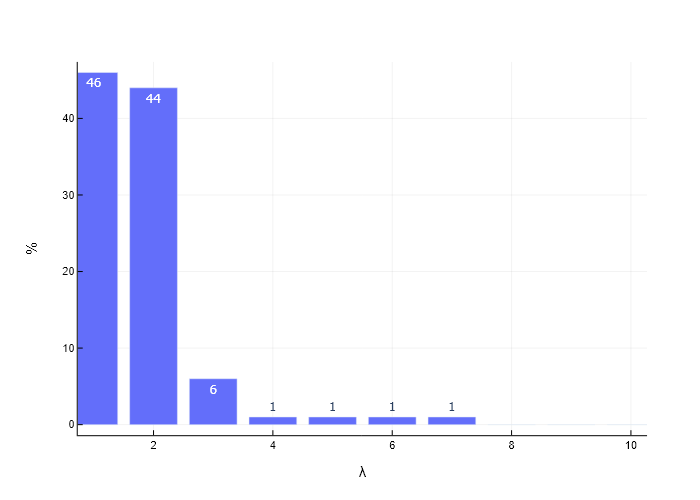

In [11]:
plot_eigen(Λ)

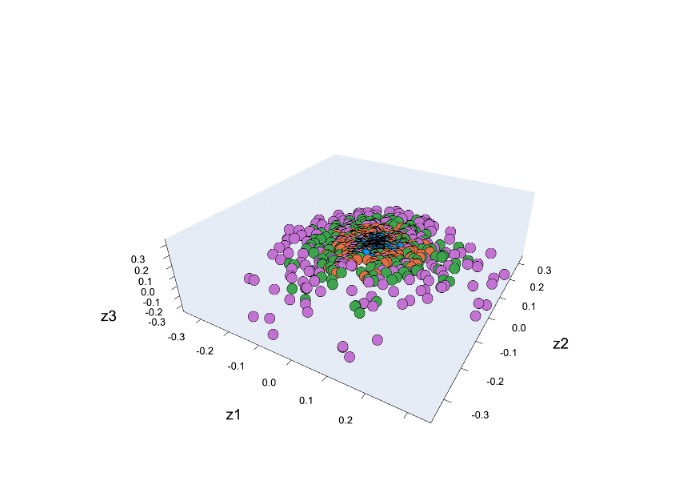

In [9]:
scatter(
    eachrow(Z_)...,xlabel="z1",ylabel="z2",zlabel="z3",
    color=[group_pot(i,N,4) for i in 1:N],
    label=false, xlims=(minimum(Z_),maximum(Z_)),
    ylims=(minimum(Z_),maximum(Z_)),
    zlims=(minimum(Z_),maximum(Z_)),
    hover=[i for i in 1:N],
    markersize=3
)

## isomap

In [10]:
println(Threads.nthreads())

20


In [12]:
neighbors = 10
Y_, D_G_sym = isomap1(neighbors,Z_)


1056 - 1005 - %100.0


([0.007452095037990708 0.025859740743915196 … -0.24691689907309397 -0.1045109494494742; -0.003875025521007139 0.03195758535110959 … 0.14067849844624714 0.013571277223718762], [0.0 0.041042156050256545 … 0.29201883897163305 0.11526771826506986; 0.041042156050256545 0.0 … 0.2976810172344034 0.1322909286983237; … ; 0.29201883897163305 0.2976810172344034 … 0.0 0.19953712049774536; 0.11526771826506986 0.1322909286983237 … 0.19953712049774536 0.0])

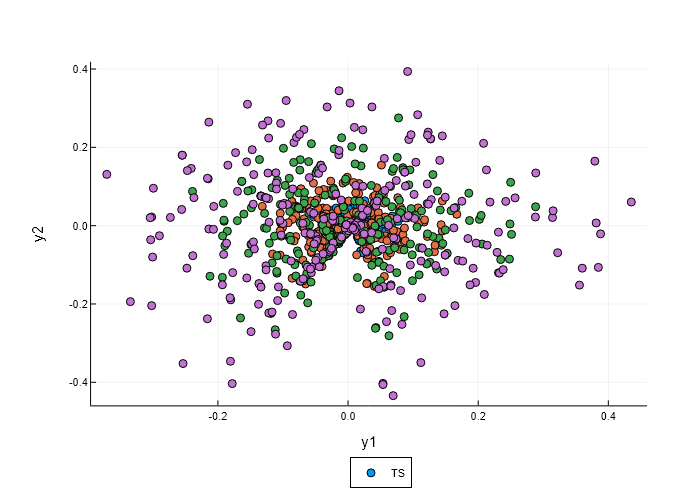

In [13]:
s = scatter(eachrow(Y_)...,xlabel="y1",ylabel="y2",label="TS",legend=:outerbottom,
    # legend_columns=2,
    color=[group_pot(i,N,4) for i in 1:N])

In [14]:
pot_list_ = []
for pot in pot_list
    push!(pot_list_,[pot for i in 1:Int(N/length(pot_list))])
end
pot_list_ = reduce(vcat,pot_list_);

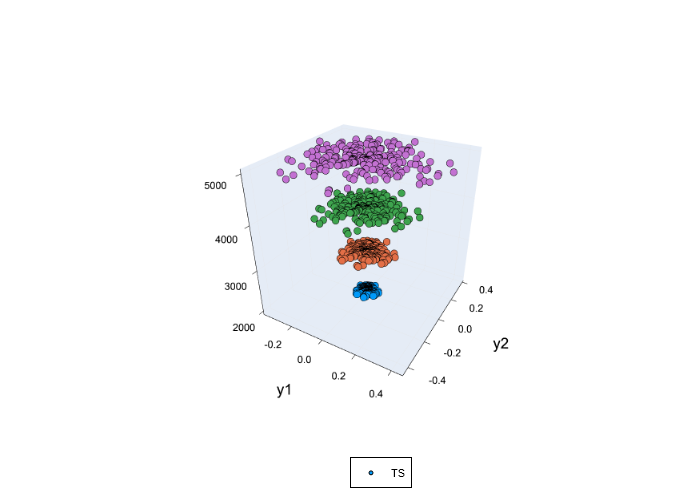

In [15]:
s = scatter(eachrow(Y_)...,pot_list_,xlabel="y1",ylabel="y2",label="TS",
    legend=:outerbottom,
    color=[group_pot(i,N,4) for i in 1:N],
    markersize=2
    )

# Test data collection

In [17]:
conf_list_test = CSV.File("data/csv/EM_TB_St4_Sl4_Phi2000_Random/EM_TB_ST4_SL4_ConfRand.csv") |> Tables.matrix
conf_list_test = conf_list_test[:,[1000-9:1000...]];
VS_Conf_list = [1:64...];

# ROM online

## Multi-voltage optimization of $\beta$

In [ ]:
Y_gen = []
for pot in pot_list
    for conf in eachcol(conf_list)
        y_gen = VectorSearch(Y_,conf,pot,pot_list,VS_Conf_list)
        push!(Y_gen,y_gen)
    end
end
Y_gen = reduce(hcat,Y_gen)

In [ ]:
Err = norm(Y_gen-Y_)/norm(Y_)

In [ ]:
function Objective(β)
    k=3
    Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    Λ, U, U_, Ḡ, G = kPOD(Κ, X, k)
    Z_ = real.(U_'*Ḡ)
    neighbors = 25
    Y_, D_G_sym = isomap1(neighbors,Z_)
    Y_gen = []
    for pot in pot_list
        for conf in eachcol(conf_list)
            y_gen = VectorSearch(Y_,conf,pot,pot_list,VS_Conf_list)
            push!(Y_gen,y_gen)
        end
    end
    Y_gen = reduce(hcat,Y_gen)
    Err = norm(Y_gen-Y_)/norm(Y_)
    return Err
end

In [ ]:
β_min = optimize(Objective, 0.0, 10.0, GoldenSection(),f_tol=1.0e-6,iterations=50)

In [ ]:
β_min.minimizer

In [ ]:
β_min.minimum

## Single test reverse map at discrete voltages

In [12]:
VS_Conf_list = [1:64...];


In [ ]:
nh = 1
n_test = 2
n_test_pot = 1
conf = conf_list_test[:,n_test]
x_test = ReadData_i(St,Sl,conf,pot_list[n_test_pot])
y_gen = VectorSearch(Y_,conf,pot_list[n_test_pot],pot_list,VS_Conf_list)


In [ ]:
plot_x(x_test,"FOS TestID=$n_test conf=$conf pot=$(pot_list[n_test_pot])")
x_gen = ReverseMap4(y_gen,conf,pot_list[n_test_pot],Y_,X,conf_list,pot_list,nh)
plot_x!(x_gen,"FOS generated BCRM")

In [ ]:
for n_test_pot in 2:4
    x_test = ReadData_i(St,Sl,conf,pot_list[n_test_pot])
    y_gen = VectorSearch(Y_,conf,pot_list[n_test_pot],pot_list,VS_Conf_list)
    plot_x!(x_test,"FOS TestID=$n_test conf=$conf pot=$(pot_list[n_test_pot])")
    x_gen = ReverseMap4(y_gen,conf,pot_list[n_test_pot],Y_,X,conf_list,pot_list,nh)
    plot_x!(x_gen,"FOS generated BCRM")
end

## Voltage interpolation 

In [ ]:
pot = 4500
pot_index = nothing
for i in 1:lastindex(pot_list)-1
    if pot>pot_list[i] && pot<pot_list[i+1]
        pot_index = i
    end
end
pot_index

In [ ]:
nh = 1
n_test = 2
conf = conf_list_test[:,n_test]
y_gen1 = VectorSearch(Y_,conf,pot_list[pot_index],pot_list,VS_Conf_list)
x_gen1 = ReverseMap4(y_gen1,conf,pot_list[pot_index],Y_,X,conf_list,pot_list,nh)
y_gen2 = VectorSearch(Y_,conf,pot_list[pot_index+1],pot_list,VS_Conf_list)
x_gen2 = ReverseMap4(y_gen2,conf,pot_list[pot_index+1],Y_,X,conf_list,pot_list,nh)
α = (pot-pot_list[pot_index])/(pot_list[pot_index+1]-pot_list[pot_index])
x_gen = x_gen1*(1-α) + x_gen2*α
plot_x(x_gen1,"AFOS @ $(pot_list[pot_index])")
plot_x!(x_gen2,"AFOS @ $(pot_list[pot_index+1])")
p = plot_x!(x_gen,"AFOS @ $pot linearly interpolated")
display(p)

In [ ]:
plotlyjs(size=(800,800))


In [ ]:
_x = ReadData_i(4,4,conf,pot)
p = plot_x(_x,"FOS @ $pot")
x_gen_pot_list = []
for pot in pot_list
    nh = 1
    n_test = 2
    conf = conf_list_test[:,n_test]
    y_gen1 = VectorSearch(Y_,conf,pot,pot_list,VS_Conf_list)
    x_gen1 = ReverseMap4(y_gen1,conf,pot,Y_,X,conf_list,pot_list,nh)
    push!(x_gen_pot_list,x_gen1)
    _x = ReadData_i(4,4,conf,pot)
    plot_x!(_x,"FOS @ $pot")
    plot_x!(x_gen1,"AFOS @ $pot")
end
x_gen_pot_list = reduce(hcat,x_gen_pot_list)
x_gen_interpol = _Interpolation(pot_list,x_gen_pot_list,pot)
p = plot_x!(x_gen_interpol, "AFOS @ $pot cuibicly interpolated")
display(p)

In [ ]:
y_gen_pot_list = []
for i in 1:lastindex(pot_list)
    y_gen = VectorSearch(Y_,conf,pot_list[i],pot_list,VS_Conf_list)
    push!(y_gen_pot_list,y_gen)
end
y_gen_pot_list = reduce(hcat,y_gen_pot_list)


In [ ]:
s = scatter(eachrow(y_gen_pot_list)...,pot_list,xlabel="y1",ylabel="y2",label="VS at voltages in TS",
xlims=(minimum(y_gen_pot_list),maximum(y_gen_pot_list)),ylims=(minimum(y_gen_pot_list),maximum(y_gen_pot_list))
)


In [ ]:
scatter(y_gen_pot_list[1,:]./minimum(y_gen_pot_list[1,:]),pot_list./maximum(pot_list),label=false)

In [ ]:
scatter(y_gen_pot_list[2,:]./minimum(y_gen_pot_list[2,:]),pot_list./maximum(pot_list),label=false)

In [ ]:
y_gen_interpol = _Interpolation(pot_list,y_gen_pot_list,pot)

In [ ]:
scatter!([y_gen_interpol[1]],[y_gen_interpol[2]],[pot],label="cubic interpolation of VS")

In [ ]:
x_gen_pot_list = []
for pot in pot_list
    nh = 1
    n_test = 2
    conf = conf_list_test[:,n_test]
    y_gen1 = VectorSearch(Y_,conf,pot,pot_list,VS_Conf_list)
    x_gen1 = ReverseMap4(y_gen1,conf,pot,Y_,X,conf_list,pot_list,nh)
    push!(x_gen_pot_list,x_gen1)
end
x_gen_pot_list = reduce(hcat,x_gen_pot_list)
x_gen_interpol = _Interpolation(pot_list,x_gen_pot_list,pot)

In [ ]:
y_new = NewData2(_x,Κ,neighbors,G,Z_,D_G_sym,Y_)

In [ ]:
scatter!([y_new[1]],[y_new[2]],[pot],label="FOS of new data introduced in RS")

In [ ]:
y_new = NewData2(x_gen_interpol,Κ,neighbors,G,Z_,D_G_sym,Y_)

In [ ]:
scatter!([y_new[1]],[y_new[2]],[pot],label="Cubic interpolation of AFOS introduced to RS")

## Optimization

In [ ]:
plotlyjs(size=(800,800))
_x = ReadData_i(4,4,conf,pot)
p = plot_x(_x,"FOS @ $pot")
x_gen_pot_list = []
for pot in pot_list
    nh = 1
    n_test = 2
    conf = conf_list_test[:,n_test]
    y_gen1 = VectorSearch(Y_,conf,pot,pot_list,VS_Conf_list)
    x_gen1 = ReverseMap4(y_gen1,conf,pot,Y_,X,conf_list,pot_list,nh)
    push!(x_gen_pot_list,x_gen1)
    _x = ReadData_i(4,4,conf,pot)
    plot_x!(_x,"FOS @ $pot")
    plot_x!(x_gen1,"AFOS @ $pot")
end
x_gen_pot_list = reduce(hcat,x_gen_pot_list)
x_gen_interpol = _Interpolation(pot_list,x_gen_pot_list,pot)
p = plot_x!(x_gen_interpol, "AFOS @ $pot cuibicly interpolated")
display(p)

In [ ]:
x_gen_opt = Voltage_Optimization2(pot_list,x_gen_pot_list,y_gen_pot_list,pot,Κ,neighbors,G,Z_,D_G_sym,Y_)

In [ ]:
plot_x!(x_gen_opt[1])

In [ ]:
norm(x_gen_interpol-_x)/norm(_x)

In [ ]:
norm(x_gen_opt[1]-_x)/norm(_x)

In [ ]:
y_new = NewData2(x_gen_opt[1],Κ,neighbors,G,Z_,D_G_sym,Y_)

In [ ]:
scatter!([y_new[1]],[y_new[2]],[pot],label="Optized interpolation coeficients for AFOS introduced to RS")

In [ ]:
x_gen_opt = Voltage_Optimization(pot_list,x_gen_pot_list,y_gen_pot_list,pot,Κ,neighbors,G,Z_,D_G_sym)

In [ ]:
y_new = NewData(x_gen_opt[1],Κ,neighbors,G,Z_,D_G_sym)

In [ ]:
scatter!([y_new[1]],[y_new[2]],[pot],label=false)

In [ ]:
plot_x!(x_gen_interpol)

# Test of new NewData function

In [ ]:
Int(conf_i + ((N/4)*(pot-1)))==N-64

In [ ]:
conf_i = 100
pot = 4
_x = ReadData_i(4,4,conf_list[:,conf_i],(pot*1000)+1000)
y = Y_[:,Int(conf_i + ((N/4)*(pot-1)))]
display(y)
y_new2 = NewData2(_x,Κ,neighbors,G,Z_,D_G_sym,Y_)
display(y_new2)
err = y_new2-y
norm(err)/norm(y)


In [ ]:
y_new = NewData(_x,Κ,neighbors,G,Z_,D_G_sym)
display(y_new)
err = y_new-y
norm(err)/norm(y)

In [ ]:
err1 = Vector{Float64}(undef,1056)
err2 = Vector{Float64}(undef,1056)
y_new2 = Matrix{Float64}(undef,2,1056)
y_new = Matrix{Float64}(undef,2,1056)
i = 1
for pot in 1:4
    println(pot)
    Threads.@threads for conf_i in 1:264
        _x = ReadData_i(4,4,conf_list[:,conf_i],pot_list[pot])
        y = Y_[:,Int(conf_i + ((N/4)*(pot-1)))]
        y_new2[:,Int(conf_i + ((N/4)*(pot-1)))] = NewData2(_x,Κ,neighbors,G,Z_,D_G_sym,Y_)
        err = y_new2[:,Int(conf_i + ((N/4)*(pot-1)))]-y
        err2[Int(conf_i + ((N/4)*(pot-1)))] = norm(err)/norm(y)
        y_new[:,Int(conf_i + ((N/4)*(pot-1)))] = NewData(_x,Κ,neighbors,G,Z_,D_G_sym)
        err = y_new[:,Int(conf_i + ((N/4)*(pot-1)))]-y
        err1[Int(conf_i + ((N/4)*(pot-1)))] = norm(err)/norm(y)
    end
end


In [ ]:
display(sum(err1)/N)

In [ ]:
display(sum(err2)/N)

In [ ]:
scatter(eachrow(Y_)...,xlabel="y1",ylabel="y2",label="TS",legend=:outerbottom,
    hover = [i for i in 1:N],
)
scatter!(eachrow(y_new)...,xlabel="y1",ylabel="y2",label="Old New Data",legend=:outerbottom,
    hover = [i for i in 1:N],
)
scatter!(eachrow(y_new2)...,xlabel="y1",ylabel="y2",label="New New Data",legend=:outerbottom,
    hover = [i for i in 1:N],  
)

# Using a configuration in the TS with a voltage that is not in the TS

In [ ]:
conf_i = 100
X̃ = [X[:,Int(conf_i + ((N/4)*(i-1)))] for i in 1:4]
X̃ = reduce(hcat,X̃)
# plot_x(X̃[:,1])
for i in 2:4
    # plot_x!(X̃[:,i])
end
x_interpol = _Interpolation(pot_list,X̃,pot)
# plot_x!(x_interpol)
Ỹ = [Y_[:,Int(conf_i + ((N/4)*(i-1)))] for i in 1:4]
Ỹ = reduce(hcat,Ỹ)
p = scatter(eachrow(Ỹ)...,pot_list,xlabel="y1",ylabel="y2",zlabel="pot",markersize=4)
pot = 4500
display(p)

In [ ]:
y_interpol = _Interpolation(pot_list,Ỹ,pot)
scatter!([y_interpol[1]],[y_interpol[2]],[pot],label="interpol",markersize=4)


In [ ]:
_x = ReadData_i(4,4,conf_list[:,conf_i],pot)
y_new = NewData2(_x,Κ,neighbors,G,Z_,D_G_sym,Y_)
scatter!([y_new[1]],[y_new[2]],[pot],label="real_new_data2",markersize=4)

In [ ]:
norm(y_new-y_interpol)

In [ ]:
y_new = NewData2(x_interpol,Κ,neighbors,G,Z_,D_G_sym,Y_)
scatter!([y_new[1]],[y_new[2]],[pot],label="interpol_new_data2",markersize=3)


In [ ]:
norm(y_new-y_interpol)

In [ ]:
i = 1
for x in eachcol(X̃)
    if i == 1
        plot_x(x,"FOS @ $(pot_list[i])")
    else
        plot_x!(x,"FOS @ $(pot_list[i])")
    end
    i += 1
end
plot_x!(_x,"FOS @ $pot")
plot_x!(x_interpol,"AFOS @ $pot cubicly interpolated")
x_interpol_l = _Interpolation(pot_list[[3,4]],X̃[:,[3,4]],pot)
p=plot_x!(x_interpol_l,"AFOS @ $pot linearly interpolated")
display(norm(x_interpol-_x)/norm(_x))
display(norm(x_interpol_l-_x)/norm(_x))
display(p)

In [ ]:
y_new = NewData(x_interpol,Κ,neighbors,G,Z_,D_G_sym)
scatter!([y_new[1]],[y_new[2]],[pot],label="interpol_vol_new_data",markersize=2)
_x = ReadData_i(4,4,conf_list[:,conf_i],pot)
y_new = NewData2(_x,Κ,neighbors,G,Z_,D_G_sym,Y_)
scatter!([y_new[1]],[y_new[2]],[pot],label="real_vol_new_data2",markersize=2)
y_new = NewData(_x,Κ,neighbors,G,Z_,D_G_sym)
scatter!([y_new[1]],[y_new[2]],[pot], label="real_vol_new_data",markersize=2)

In [ ]:
x_gen_opt = Voltage_Optimization(pot_list,X̃,Ỹ,pot,Κ,neighbors,G,Z_,D_G_sym)

In [ ]:
x_gen_opt = Voltage_Optimization2(pot_list,X̃,Ỹ,pot,Κ,neighbors,G,Z_,D_G_sym)

In [ ]:
y_new = NewData(x_gen_opt[1],Κ,neighbors,G,Z_,D_G_sym)
scatter!([y_new[1]],[y_new[2]],[pot],label=false)

In [ ]:
conf_i = 100
X̃ = [X[:,Int(conf_i + ((N/4)*(i-1)))] for i in 1:4]
X̃ = reduce(hcat,X̃)
plot_x(X̃[:,1])
for i in 2:4
    plot_x!(X̃[:,i])
end
x_interpol = _Interpolation(pot_list,X̃,pot)
plot_x!(x_interpol)


In [ ]:
plot_x!(x_gen_opt[1])

In [ ]:
conf_list[:,conf_i]'

In [ ]:
_x = ReadData_i(4,4,conf_list[:,conf_i],pot)
plot_x!(_x)

In [ ]:
C = Y_*Y_'
inv(C)

# Interpolating the whole training set to the desired voltage

In [ ]:
_x = ReadData_i(4,4,conf,pot)
p = plot_x(_x,"FOS @ $pot")
x_gen_pot_list = []
for pot in pot_list
    nh = 1
    n_test = 2
    conf = conf_list_test[:,n_test]
    y_gen1 = VectorSearch(Y_,conf,pot,pot_list,VS_Conf_list)
    x_gen1 = ReverseMap4(y_gen1,conf,pot,Y_,X,conf_list,pot_list,nh)
    push!(x_gen_pot_list,x_gen1)
    _x = ReadData_i(4,4,conf,pot)
    plot_x!(_x,"FOS @ $pot")
    plot_x!(x_gen1,"AFOS @ $pot")
end
x_gen_pot_list = reduce(hcat,x_gen_pot_list)
# x_gen_interpol = _Interpolation(pot_list,x_gen_pot_list,pot)
x_gen_interpol = ReverseMap5(conf,pot,Y_,X,conf_list,pot_list,nh)
p = plot_x!(x_gen_interpol, "AFOS @ $pot cuibicly interpolated")
x_gen_interpol = ReverseMap6(conf,pot,Y_,X,conf_list,pot_list,nh)
p = plot_x!(x_gen_interpol, "AFOS @ $pot cuibicly interpolating the TS then ReverseMap")
display(p)

# Optimization to find Configuration and voltage of desired shape

## Data for optimization and comparisons

In [18]:
nh = 1
n_test = 9
conf = conf_list_test[:,n_test]
pot = 4500
x_gen_interpol = ReverseMap6(conf,pot,Y_,X,conf_list,pot_list,nh)
_x = ReadData_i(4,4,conf,pot)
p = plot_x(_x,"FOS @ $pot")
p = plot_x!(x_gen_interpol, "AFOS @ $pot cuibicly interpolating the TS then ReverseMap")
Err = norm(x_gen_interpol-_x)/norm(_x)


0.0056676943392836516

In [19]:
y_new_real = NewData2(_x,Κ,neighbors,G,Z_,D_G_sym,Y_)
y_new_int = NewData2(x_gen_interpol,Κ,neighbors,G,Z_,D_G_sym,Y_)
Err = norm(y_new_int-y_new_real)/norm(y_new_real)
Err2 = Κ(x_gen_interpol,_x)
y_gen = VectorSearch2(Y_,conf,pot,pot_list,VS_Conf_list)
Err3 = norm(y_gen-y_new_real)/norm(y_new_real)
println((Err,Err3))

(0.04376522514622727, 0.14932117238741227)


In [ ]:
(1-Err2)^2

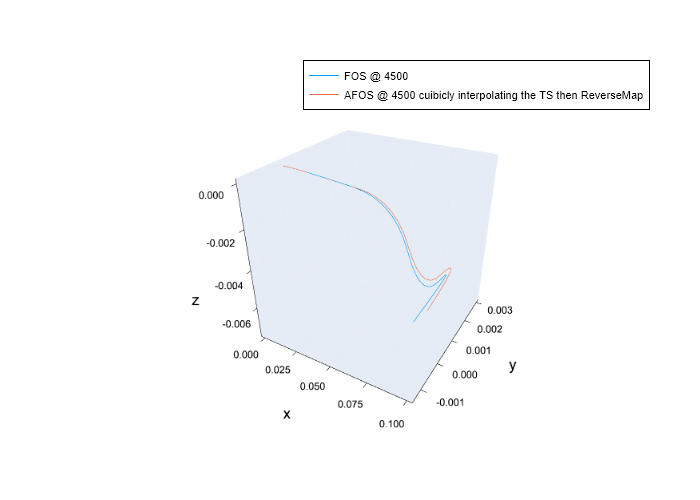

In [20]:
display(p)

In [21]:
function Obj_0(α)
    pot = α[1]
    conf = Int.(round.(α[[2:end...]],digits=0))
    x_gen_interpol = ReverseMap6(conf,pot,Y_,X,conf_list,pot_list,nh)
    Err = (1-Κ(x_gen_interpol,_x))^2
    return Err
end

Obj_0 (generic function with 1 method)

In [22]:
Obj_0(vcat(pot,conf))

6.951866868285244e-11

## Optimization over $\Kappa$ of desired shape and Reversemap

### 100 particles

In [383]:
using Optim

In [ ]:
_Opt = optimize(
    Obj_0,
    [2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
    ParticleSwarm( lower = [2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                upper = [5000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
                n_particles = 100),
    Optim.Options(
        time_limit = 60.0*5.0,
        iterations = Int(1e5),
    )
)

### 1000 particles

In [25]:
_Opt = optimize(
    Obj_0,
    [2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
    ParticleSwarm( lower = [2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                upper = [5000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
                n_particles = 100000),
    Optim.Options(
        time_limit = 60.0*5.0,
        iterations = Int(1e5),
        show_trace = true,
    )
)

## Test of result in optimization

In [24]:
display(Int.(vcat(round(_Opt.minimizer[1],digits=0),Int.(round.(_Opt.minimizer[[2:end...]],digits=0))))')
vcat(pot,conf)'

1×17 adjoint(::Vector{Int64}) with eltype Int64:
 3591  0  1  0  0  1  0  0  1  0  0  1  1  0  0  0  1

1×17 adjoint(::Vector{Int64}) with eltype Int64:
 4500  1  1  1  0  1  1  0  1  0  0  1  1  1  0  0  1

In [ ]:
x_gen_interpol = ReverseMap6(Int.(round.(_Opt.minimizer[[2:end...]],digits=0)),round(_Opt.minimizer[1],digits=0),Y_,X,conf_list,pot_list,nh)
p = plot_x!(x_gen_interpol, "AFOS of the optimization result")

In [ ]:
_Opt.minimum

In [ ]:
y_new = NewData2(_x,Κ,neighbors,G,Z_,D_G_sym,Y_)


In [ ]:
y_new = NewData(_x,Κ,neighbors,G,Z_,D_G_sym)

In [ ]:
y_gen = VectorSearch2(Y_,conf,pot,pot_list,VS_Conf_list)

In [ ]:
function Obj_1(α)
    pot = α[1]
    conf = Int.(round.(α[[2:end...]],digits=0))
    y_gen = VectorSearch2(Y_,conf,pot,pot_list,VS_Conf_list)
    Err = norm(y_gen-y_new)/norm(y_new)
    return Err
end

In [ ]:
Obj_1(vcat(pot,conf))

In [ ]:
_Opt = optimize(
    Obj_1,
    [2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
    ParticleSwarm( lower = [2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                upper = [5000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
                n_particles = 50),
    Optim.Options(
        time_limit = 60.0
    )
)

In [ ]:
display(vcat(round(_Opt.minimizer[1],digits=0),Int.(round.(_Opt.minimizer[[2:end...]],digits=0)))')
vcat(pot,conf)'

In [ ]:
x_gen_interpol = ReverseMap6(Int.(round.(_Opt.minimizer[[2:end...]],digits=0)),round(_Opt.minimizer[1],digits=0),Y_,X,conf_list,pot_list,nh)
p = plot_x!(x_gen_interpol, "AFOS @ $pot cuibicly interpolating the TS then ReverseMap")

In [ ]:
_Opt = optimize(
    Obj_1,
    [2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
    ParticleSwarm( lower = [2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                upper = [5000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
                n_particles = 50.0),
    Optim.Options(
        time_limit = 60.0
    )
)